In [2]:
# =============================================================================
# Imports and Device Setup
# =============================================================================
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary


In [3]:
# Automatically choose device: GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
def load_cifar_batch(file_path):
    """
    Load a CIFAR batch from a pickle file.
    
    Args:
        file_path (str): Path to the CIFAR batch pickle file.
        
    Returns:
        dict: Dictionary containing the data and labels.
    """
    with open(file_path, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
    return data_dict

In [6]:
# Directory containing CIFAR-10 training batches (update the path if necessary)
cifar10_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

# Load metadata to get label names
meta_data = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data[b'label_names']]

# Load and concatenate training data from all batches
train_data_list = []
train_labels_list = []
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    train_data_list.append(batch[b'data'])
    train_labels_list += batch[b'labels']

# Convert training data to a NumPy array and reshape into image format (HWC)
train_data = np.vstack(train_data_list).reshape(-1, 3, 32, 32)
train_data = np.transpose(train_data, (0, 2, 3, 1))  # Change from CHW to HWC format
train_labels = np.array(train_labels_list)

# Data augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.ToPILImage(),                     # Convert NumPy array to PIL Image
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), value=1.0)
])

# Define a custom Dataset class for CIFAR-10
class CustomCIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Initialize dataset.
        
        Args:
            images (np.array): Array of images.
            labels (np.array): Array of labels.
            transform: Transformations to be applied to each image.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Retrieve image and label
        img = self.images[idx]
        label = self.labels[idx]
        # Apply transformation if provided
        if self.transform:
            img = self.transform(img)
        return img, label

In [7]:
# Create the training dataset with transformations
full_train_dataset = CustomCIFAR10Dataset(train_data, train_labels, transform=train_transform)

# Split the dataset into training (90%) and validation (10%) sets
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# DataLoaders for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

In [8]:
# Path to the test dataset (unlabeled)
cifar_test_path = '/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'
test_batch = load_cifar_batch(cifar_test_path)
# Normalize test images to range [0, 1]
test_images = test_batch[b'data'].astype(np.float32) / 255.0

# Test transform: only normalization and tensor conversion (no augmentation)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
# Create test dataset as a list of transformed images (wrapped in tuples for DataLoader compatibility)
test_dataset = [(test_transform(img),) for img in test_images]
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)


In [9]:
# Model Definition: Residual Block and Custom ResNet
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        A single residual block with two convolutional layers.
        """
        super(ResidualBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection to match dimensions if needed
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        """
        A custom ResNet model for CIFAR-10 classification.
        """
        super(CustomResNet, self).__init__()
        # Initial convolution layer
        self.init_conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.init_bn   = nn.BatchNorm2d(64)
        self.relu      = nn.ReLU(inplace=True)
        # Residual layers
        self.layer1 = self._make_layer(64, 64, blocks=6, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        # Global average pooling and final fully-connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc       = nn.Linear(256, num_classes)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        """
        Create a layer consisting of several residual blocks.
        """
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.init_conv(x)
        out = self.init_bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# Model Initialization and Summary
model = CustomResNet(num_classes=10).to(device)
print("Model Summary:")
summary(model, (3, 32, 32))

# Additionally, print total number of trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal number of trainable parameters: {num_params}")


Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
    ResidualBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14    

In [10]:
def train_model(model, train_loader, val_loader, epochs=50):
    """
    Train the model and evaluate on the validation set after each epoch.
    
    Returns:
        train_losses (list): Average training loss for each epoch.
        val_accuracies (list): Validation accuracy (in %) for each epoch.
    """
    criterion = nn.CrossEntropyLoss()
    # Use SGD optimizer with a learning rate of 0.007, momentum, and weight decay
    optimizer = optim.SGD(model.parameters(), lr=0.007, momentum=0.9, weight_decay=1e-4)
    # Learning rate scheduler: decay LR by a factor of 0.9 every 10 epochs
    scheduler = StepLR(optimizer, step_size=10, gamma=0.9)
    
    train_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Compute average training loss
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)
        
        # Step the learning rate scheduler
        scheduler.step()
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    
    return train_losses, val_accuracies

Epoch 1/30, Loss: 1.5263, Validation Accuracy: 43.54%
Epoch 2/30, Loss: 1.0888, Validation Accuracy: 53.12%
Epoch 3/30, Loss: 0.8917, Validation Accuracy: 61.84%
Epoch 4/30, Loss: 0.7606, Validation Accuracy: 72.06%
Epoch 5/30, Loss: 0.6698, Validation Accuracy: 72.18%
Epoch 6/30, Loss: 0.6122, Validation Accuracy: 74.24%
Epoch 7/30, Loss: 0.5619, Validation Accuracy: 75.84%
Epoch 8/30, Loss: 0.5223, Validation Accuracy: 73.46%
Epoch 9/30, Loss: 0.4859, Validation Accuracy: 77.80%
Epoch 10/30, Loss: 0.4527, Validation Accuracy: 80.30%
Epoch 11/30, Loss: 0.4116, Validation Accuracy: 83.40%
Epoch 12/30, Loss: 0.3967, Validation Accuracy: 80.60%
Epoch 13/30, Loss: 0.3838, Validation Accuracy: 83.86%
Epoch 14/30, Loss: 0.3599, Validation Accuracy: 81.86%
Epoch 15/30, Loss: 0.3450, Validation Accuracy: 79.60%
Epoch 16/30, Loss: 0.3317, Validation Accuracy: 84.18%
Epoch 17/30, Loss: 0.3206, Validation Accuracy: 84.50%
Epoch 18/30, Loss: 0.3047, Validation Accuracy: 85.18%
Epoch 19/30, Loss: 

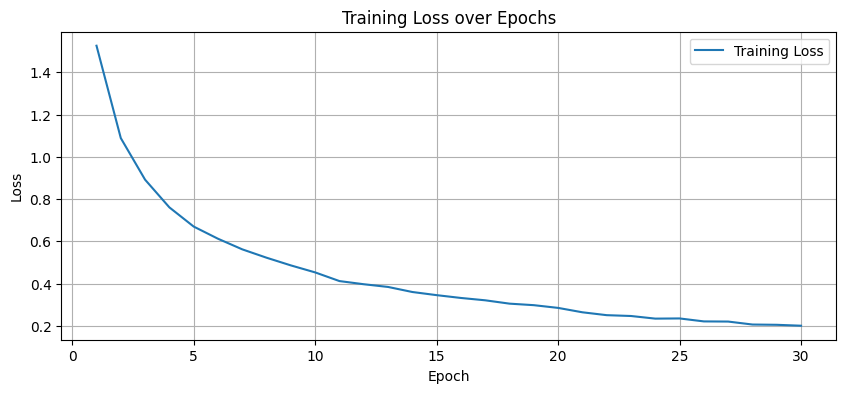

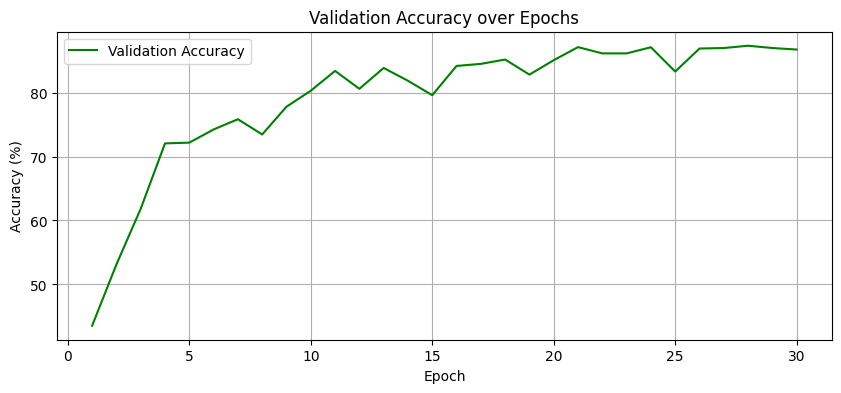

In [11]:
# Model Training and Evaluation
# Train the model for the specified number of epochs (e.g., 100)
epochs = 30
train_losses, val_accuracies = train_model(model, train_loader, val_loader, epochs=epochs)

# Final validation accuracy (used as a proxy for test accuracy)
final_val_acc = val_accuracies[-1]
print(f"\nFinal Validation Accuracy: {final_val_acc:.2f}%")

# Plot Training Loss and Validation Accuracy
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Test Predictions and Submission File Generation
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_loader:
        # Each batch item is a tuple; get the image tensor and move to device
        images = batch[0].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Generate submission DataFrame and save to CSV file
submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission_path = '/kaggle/working/submission.csv'
submission.to_csv(submission_path, index=False)
print(f"Submission file saved at: {submission_path}")


Submission file saved at: /kaggle/working/submission.csv


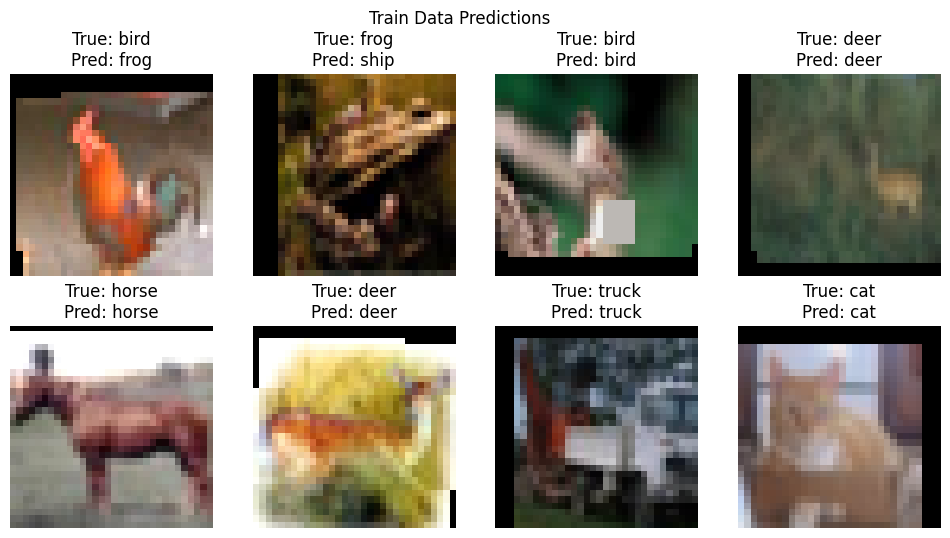

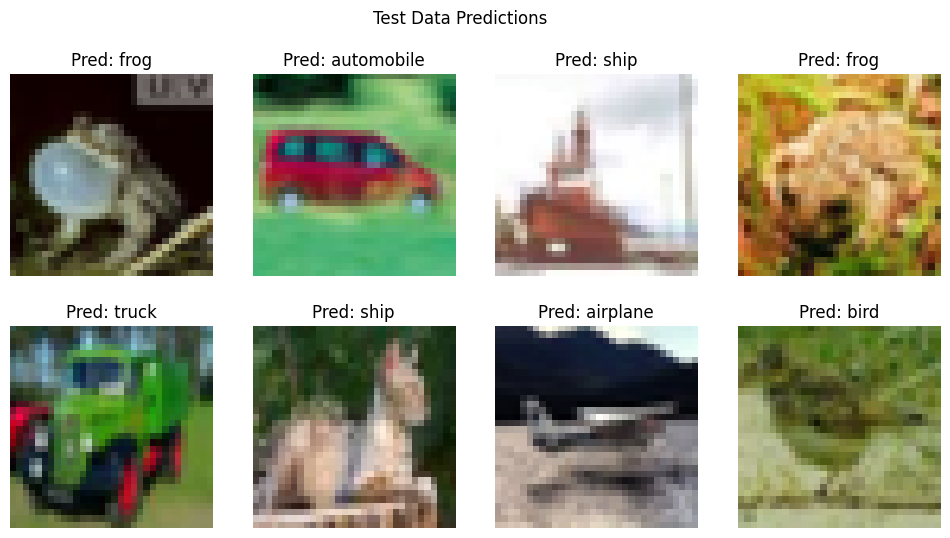

In [13]:
import matplotlib.pyplot as plt

# Utility function to unnormalize images for display
def unnormalize(img):
    """
    Unnormalize a tensor image using the CIFAR-10 normalization parameters.
    """
    mean = torch.tensor([0.4914, 0.4822, 0.4465], device=img.device).view(3, 1, 1)
    std = torch.tensor([0.247, 0.243, 0.261], device=img.device).view(3, 1, 1)
    return img * std + mean

# ---------------------------
# Display True & Predicted Labels on Train Data
# ---------------------------
model.eval()  # Set the model to evaluation mode
# Get one batch from the train_loader
train_iter = iter(train_loader)
train_images, train_labels = next(train_iter)
train_images, train_labels = train_images.to(device), train_labels.to(device)

with torch.no_grad():
    outputs = model(train_images)
    _, train_predicted = torch.max(outputs, 1)

# Plot first 8 training images with true and predicted labels
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()
for idx, ax in enumerate(axes):
    # Unnormalize the image for visualization
    img = unnormalize(train_images[idx]).cpu().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Ensure pixel values are within [0, 1]
    ax.imshow(img)
    ax.axis('off')
    true_label = label_names[train_labels[idx].item()] if label_names else str(train_labels[idx].item())
    pred_label = label_names[train_predicted[idx].item()] if label_names else str(train_predicted[idx].item())
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
plt.suptitle("Train Data Predictions")
plt.show()

# ---------------------------
# Display Predicted Labels on Test Data
# ---------------------------
# Get one batch from the test_loader (test set is unlabeled)
test_iter = iter(test_loader)
test_batch = next(test_iter)
test_images = test_batch[0].to(device)

with torch.no_grad():
    outputs = model(test_images)
    _, test_predicted = torch.max(outputs, 1)

# Plot first 8 test images with predicted labels
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()
for idx, ax in enumerate(axes):
    img = unnormalize(test_images[idx]).cpu().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')
    pred_label = label_names[test_predicted[idx].item()] if label_names else str(test_predicted[idx].item())
    ax.set_title(f"Pred: {pred_label}")
plt.suptitle("Test Data Predictions")
plt.show()
